In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port, ortho_port
from optimization_scipy import Optimization_Scipy as Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 2.0e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L1 = 14         # length waveguides in design region (L0)
L2 = 9          # width of box (L0)
H = 10          # height waveguides in design region (L0)
H2 = 6          # height of box (L0)
w = .3          # width of waveguides (L0)
l = 4           # length of waveguide from PML to box (L0)
spc = 3         # space between box and PML (L0)

Computed a domain with 140 grids in x and 120 grids in y
The simulation has 10 grids per free space wavelength


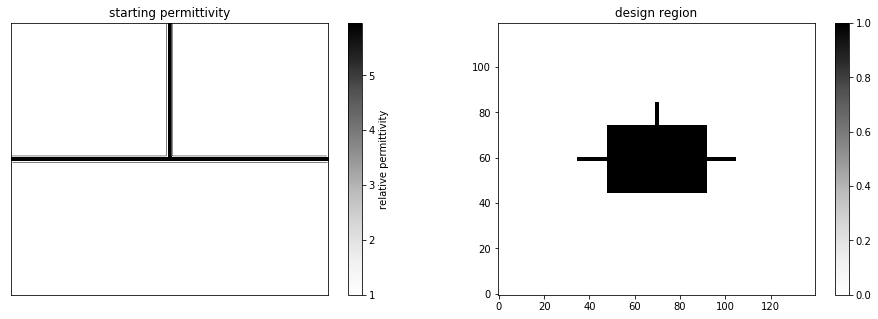

In [5]:
# define permittivity of three port system
eps_r, design_region = ortho_port(L1, L2, H, H2, w, l, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('starting permittivity')
a = ax2.imshow(design_region.T, origin='lower', cmap='Greys')
plt.colorbar(a, ax=ax2)
ax2.set_title('design region')
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'y', [nx, -NPML[1]-int(l/2/dl)], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# left modal profile
left = Simulation(omega, eps_r, dl, NPML, 'Ez')
left.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl))
left.setup_modes()
J_left = np.abs(left.src)

# right modal profile
right = Simulation(omega, eps_r, dl, NPML, 'Ez')
right.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
right.setup_modes()
J_right = np.abs(right.src)

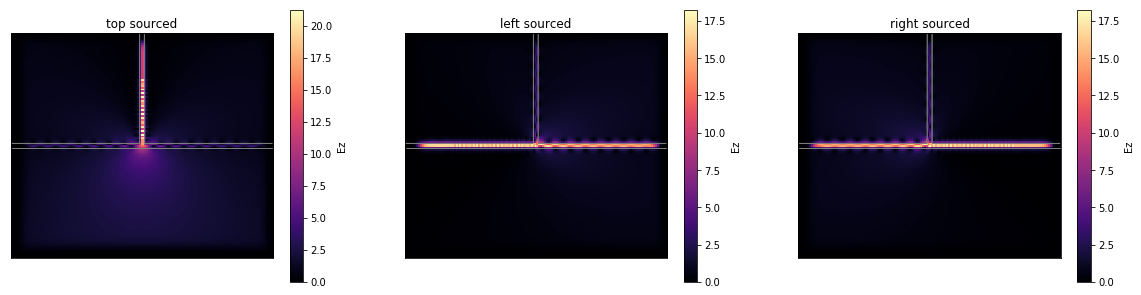

In [7]:
# set source and solve for electromagnetic fields
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

_ = simulation.solve_fields()
_ = left.solve_fields()
_ = right.solve_fields()

simulation.plt_abs(outline=True, cbar=True, ax=ax1)
left.plt_abs(outline=True, cbar=True, ax=ax2)
right.plt_abs(outline=True, cbar=True, ax=ax3)
ax1.set_title('top sourced')
ax2.set_title('left sourced')
ax3.set_title('right sourced')
plt.show()

computed a scale of 352.38745922439045 in units of E^2 J_out


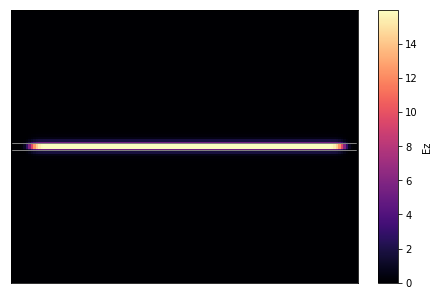

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L1, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(H/2/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
simulation_wg.plt_abs()

print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

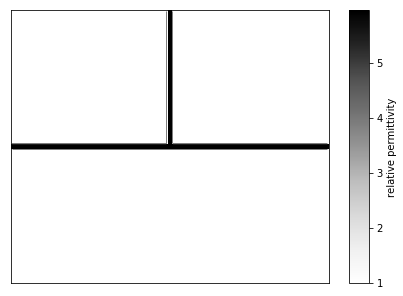

In [9]:
# set the design region to whatever you want in {'clean','halfway','random'} if None, then uses current eps of simulation
initialize = 'clean'
if initialize == 'halfway':
    eps_halfway = simulation.eps_r
    eps_halfway[design_region == 1] = eps_m/2 + 1/2
    simulation.eps_r = eps_halfway
elif initialize == 'random':
    eps_random = (eps_m-1)*np.random.random(simulation.eps_r.shape)+1
    eps_random[design_region == 0] = simulation.eps_r[design_region == 0]
    simulation.eps_r = eps_random
elif initialize == 'clean':
    eps_clean, _ = ortho_port(L1, L2, H, H2, w, l, dl, NPML, eps_m)
    simulation.eps_r = eps_clean
    
simulation.plt_eps()
plt.show()

In [10]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [11]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
        MAKE SURE YOU USE npa. instead of np.   !!!
    """
    Binary_Penalty = 1e-2
    BOOST = 1e5    
    linear_right =     1*npa.sum(npa.square(npa.abs(e))*J_right)
    linear_left =     -1*npa.sum(npa.square(npa.abs(e))*J_left)
    nonlinear_right = -1*npa.sum(npa.square(npa.abs(e_nl))*J_right)
    nonlinear_left =   1*npa.sum(npa.square(npa.abs(e_nl))*J_left)
    objfn = (linear_right + linear_left + nonlinear_right + nonlinear_left)/2
    objfn_binary = objfn - Binary_Penalty*npa.sum(npa.square(eps*design_region - npa.ones(eps.shape))*npa.square(eps*design_region - eps_m*npa.ones(eps.shape))) / Nx / Ny
    return objfn / SCALE * BOOST

In [ ]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=80, eps_max=eps_m, field_start='linear', nl_solver='newton')

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-0.0164919889873687, 0.02542325531944556, -0.03838228631923357, -0.018425477651334177]
numerical gradient = [-0.016491335607031303, 0.025423651009534476, -0.03838181617184439, -0.018418317849187044]


In [ ]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region, method='lbfgs')
# new_eps = optimization.run(simulation, design_region, method='gd', step_size=1e3)
# new_eps = optimization.run(simulation, design_region, method='adam', step_size=1e-2, beta1=0.9, beta2=.999)

 ObjectiveFn:   24.8 Iteration:  12/80 ETA:   0:05:19                          

In [ ]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('log')
plt.show()

In [ ]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

In [ ]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [ ]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_right_lin =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H/2))
W_left_lin  = -simulation.flux_probe('x', [ NPML[0]+int(l/2/dl), ny], int(H/2))

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_right_nl =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H/2))
W_left_nl  = -simulation.flux_probe('x', [ NPML[0]+int(l/2/dl), ny], int(H/2))


print('linear power (right)              = {:.4f}'.format(W_right_lin))
print('linear power (left)               = {:.4f}'.format(W_left_lin))
print('nonlinear power (right)           = {:.4f}'.format(W_right_nl))
print('nonlinear power (left)            = {:.4f}'.format(W_left_nl))
print('relative power difference (right)        = {:.2f} %'.format(100*abs(W_right_lin - W_right_nl) / W_right_lin))
print('relative power difference (left)         = {:.2f} %'.format(100*abs(W_left_lin  - W_left_nl)  / W_left_lin))

S = [[W_left_lin, W_right_lin],
     [W_left_nl,  W_right_nl]]
plt.imshow(S, cmap='magma')
plt.colorbar()

In [ ]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=50, df=1/1000)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))